In [71]:
!pip install split-folders

### **Importing of Necessary Libraries**

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [73]:
import wandb
from wandb.keras import WandbCallback
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api") 
wandb.login(key=wandb_api)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### **Dataset Loading and Splitting**
Split-folders library was used to split the dataset into three parts: Training set(60%), Validation set(20%), and Test set(20%).

In [74]:
base_ds = '/kaggle/input/btp-dataset/dataset btp'
base_ds = pathlib.Path(base_ds)

In [75]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 750 files [00:23, 31.41 files/s] 


In [76]:


Alnus_incana= [fn for fn in os.listdir(f'{base_ds}/Alnus_incana') if (fn.endswith('.jpg') or fn.endswith('.jpeg') or fn.endswith('.tif'))]
Fagus_silvatica= [fn for fn in os.listdir(f'{base_ds}/Fagus_silvatica') if (fn.endswith('.jpg') or fn.endswith('.jpeg')or  fn.endswith('.tif'))]
Populus= [fn for fn in os.listdir(f'{base_ds}/Populus') if (fn.endswith('.jpg') or fn.endswith('.jpeg') or fn.endswith('.tif'))]
Populus_tremula= [fn for fn in os.listdir(f'{base_ds}/Populus_tremula') if (fn.endswith('.jpg') or fn.endswith('.jpeg') or fn.endswith('.tif'))]
Quercus= [fn for fn in os.listdir(f'{base_ds}/Quercus') if (fn.endswith('.jpg') or fn.endswith('.jpeg') or fn.endswith('.tif'))]
Salix_alba= [fn for fn in os.listdir(f'{base_ds}/Salix_alba') if (fn.endswith('.jpg') or fn.endswith('.jpeg') or fn.endswith('.tif'))]
Salix_aurita= [fn for fn in os.listdir(f'{base_ds}/Salix_aurita') if (fn.endswith('.jpg') or fn.endswith('.jpeg') or fn.endswith('.tif'))]
Salix_senerea= [fn for fn in os.listdir(f'{base_ds}/Salix_senerea') if (fn.endswith('.jpg') or fn.endswith('.jpeg') or fn.endswith('.tif'))]


Tilia= [fn for fn in os.listdir(f'{base_ds}/Tilia') if (fn.endswith('.jpg') or fn.endswith('.jpeg') or fn.endswith('.tif'))]
Ulmus_carpinifolia= [fn for fn in os.listdir(f'{base_ds}/Ulmus_carpinifolia') if (fn.endswith('.jpg') or fn.endswith('.jpeg') or fn.endswith('.tif'))]



coffee= [Alnus_incana, Fagus_silvatica, Populus, Populus_tremula, Quercus, Salix_alba, Salix_aurita, Salix_senerea, Tilia, Ulmus_carpinifolia]
coffee_classes = []
for i in os.listdir('imgs/train'):
    coffee_classes+=[i]
coffee_classes.sort()



### **Dataset Exploration**
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

Total images: 750
Total number of classes: 10
Total Alnus_incana images: 75
Total Fagus_silvatica images: 75
Total Populus images: 75
Total Populus_tremula images: 75
Total Quercus images: 75
Total Salix_alba images: 75
Total Salix_aurita images: 75
Total Salix_senerea images: 75
Total Tilia images: 75
Total Ulmus_carpinifolia images: 75


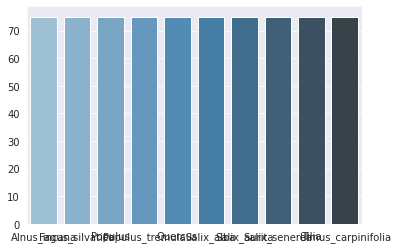

In [77]:
image_count1= len(list(base_ds.glob('*/*.jpg')))
image_count2 = len(list(base_ds.glob('*/*.jpeg')))
image_count3= len(list(base_ds.glob('*/*.tif')))
image_count=image_count1+image_count2+image_count3
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(coffee_classes)}')
count = 0
coffee_count = []
for x in coffee_classes:
  print(f'Total {x} images: {len(coffee[count])}')
  coffee_count.append(len(coffee[count]))
  count+=1

sns.set_style('darkgrid')
sns.barplot(x=coffee_classes, y=coffee_count, palette="Blues_d")
plt.show()

### Sample Images
Each image from the dataset has a dimension of 250 by 250 and a color type of RGB

Image dimensions: (1206, 697, 3)


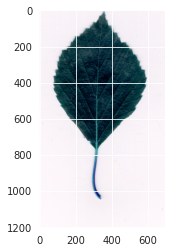

In [78]:
sample_img = cv2.imread('/kaggle/input/btp-dataset/dataset btp/Alnus_incana/l5nr001.tif')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [79]:
def load_random_img(dir, label):
  plt.figure(figsize=(20,40))
  i=0
  for label in coffee_classes:
    i+=1
    plt.subplot(1,10, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

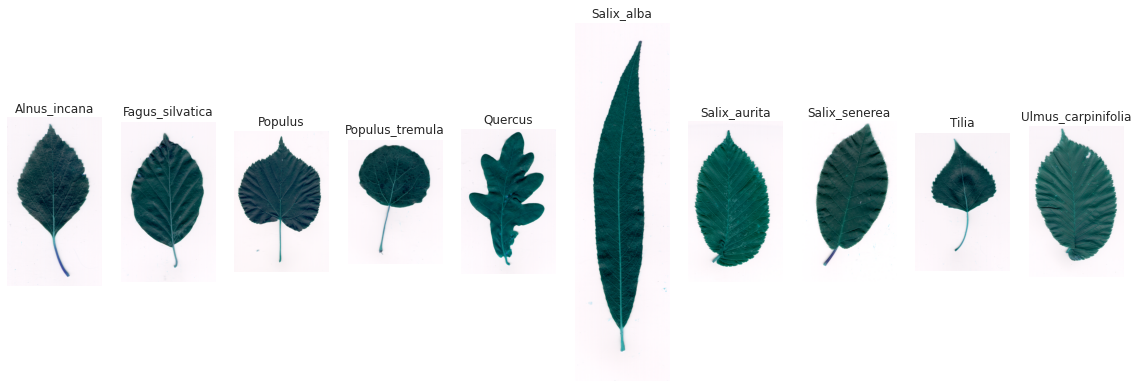

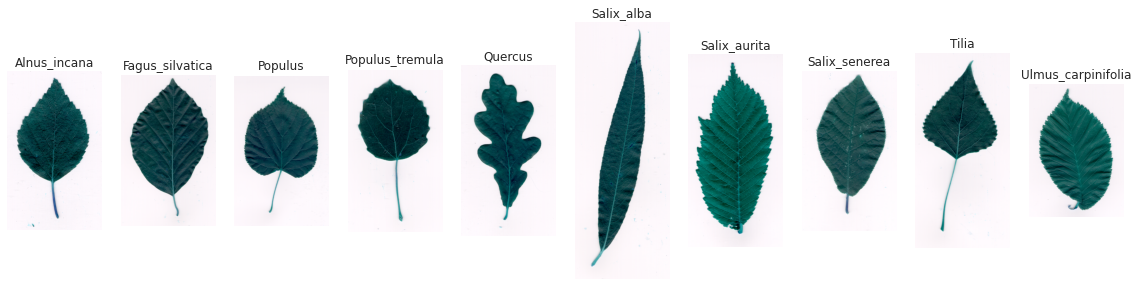

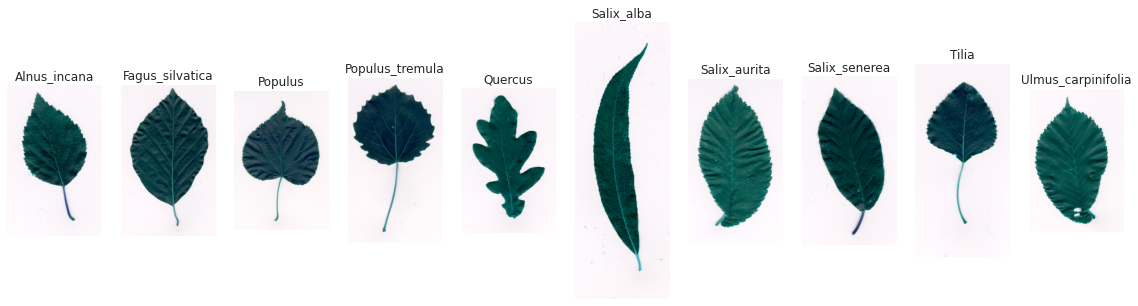

In [80]:
for i in range(3):
  load_random_img(base_ds,coffee_classes)

In [81]:
batch_size =10
img_height, img_width =128,128
input_shape = (img_height, img_width, 3)

CONFIG=dict(
            batch_size =128,
            img_height=128,
            img_width =128,
            )

### **Data Pre-processing**

In [82]:
train_datagen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               zoom_range=0.15,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.15,
                               horizontal_flip=True,
                               fill_mode="nearest")

test_datagen=ImageDataGenerator(rescale=1./255)

In [83]:
train_ds = train_datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical',
    shuffle=True
    )

val_ds = train_datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = test_datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 520 images belonging to 10 classes.
Found 110 images belonging to 10 classes.
Found 120 images belonging to 10 classes.


In [84]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [85]:
CONFIG['model_name'] = 'InceptionResNetV2'
print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='10plantleaves',
                 config=CONFIG,
                 group='InceptionResNetV2', 
                 job_type='train')

wandb.config.type = 'baseline'

Training configuration:  {'batch_size': 128, 'img_height': 128, 'img_width': 128, 'model_name': 'InceptionResNetV2'}


## **Transfer Learning**

In [86]:
model=tf.keras.applications.InceptionResNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = True
inputs = tf.keras.Input(input_shape)
x = model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)
model= tf.keras.Model(inputs, x)

In [87]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 55,920,874
Trainable params: 55,860,330
Non-trainable params: 60,544
_________________________________________________________________


## **Fine Tuning**

In [88]:
history3 =model.fit(train_ds, epochs =15, validation_data = val_ds,callbacks=[WandbCallback()])
run.finish()

2022-12-14 07:25:54.275132: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-12-14 07:25:54.275660: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-12-14 07:25:54.334042: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.025ms.
  function_optimizer: function_optimizer did nothing. time = 0.002ms.



Epoch 1/15
52/52 [==============================] - 128s 2s/step - loss: 1.4365 - accuracy: 0.5212 - val_loss: 0.4304 - val_accuracy: 0.8455
Epoch 2/15
52/52 [==============================] - 95s 2s/step - loss: 0.3276 - accuracy: 0.9019 - val_loss: 0.1290 - val_accuracy: 0.9636
Epoch 3/15
52/52 [==============================] - 91s 2s/step - loss: 0.1798 - accuracy: 0.9442 - val_loss: 0.1154 - val_accuracy: 0.9545
Epoch 4/15
52/52 [==============================] - 91s 2s/step - loss: 0.1427 - accuracy: 0.9519 - val_loss: 0.0829 - val_accuracy: 0.9636
Epoch 5/15
52/52 [==============================] - 95s 2s/step - loss: 0.0994 - accuracy: 0.9692 - val_loss: 0.0699 - val_accuracy: 0.9727
Epoch 6/15
52/52 [==============================] - 101s 2s/step - loss: 0.0928 - accuracy: 0.9673 - val_loss: 0.0267 - val_accuracy: 1.0000
Epoch 7/15
52/52 [==============================] - 94s 2s/step - loss: 0.0544 - accuracy: 0.9865 - val_loss: 0.0230 - val_accuracy: 0.9909
Epoch 8/15
52/52 [

accuracy,▁▇▇▇███████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▆▇███▇███▇██
val_loss,█▃▃▂▂▁▁▂▁▁▁▁▂▁▁
GFLOPS,1.62713
accuracy,0.99231
best_epoch,11
best_val_loss,0.00501
epoch,14
loss,0.05027


## **Final Evaluation**

In [89]:
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='10plantleaves', 
                 config=CONFIG,
                 group='InceptionResNetV2', 
                 job_type='evaluate') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

# Finish the run
run.finish()

12/12 [==============================] - 11s 852ms/step - loss: 0.0791 - accuracy: 0.9750


In [90]:
print(f'Pretrained Network Fine-tuned "\n"Loss: {score3[0]},"\n" Accuracy: {score3[1]*100}')

Pretrained Network Fine-tuned "
"Loss: 0.07906913012266159,"
" Accuracy: 97.50000238418579


In [91]:
Y_pred =model.predict(test_ds)

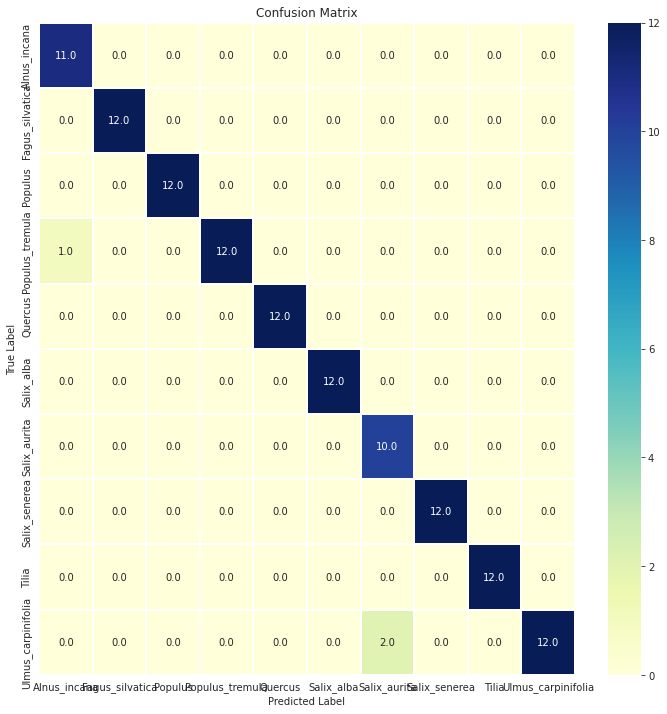

In [92]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(coffee_classes)
plt.title("Confusion Matrix")
plt.show()

In [93]:
report2 = classification_report(test_ds.classes, y_pred, target_names=coffee_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

,precision,recall,f1-score,support
Alnus_incana,1.000000,0.916667,0.956522,12.000
Fagus_silvatica,1.000000,1.000000,1.000000,12.000
Populus,1.000000,1.000000,1.000000,12.000
Populus_tremula,0.923077,1.000000,0.960000,12.000
Quercus,1.000000,1.000000,1.000000,12.000
Salix_alba,1.000000,1.000000,1.000000,12.000
Salix_aurita,1.000000,0.833333,0.909091,12.000
Salix_senerea,1.000000,1.000000,1.000000,12.000
Tilia,1.000000,1.000000,1.000000,12.000
Ulmus_carpinifolia,0.857143,1.000000,0.923077,12.000


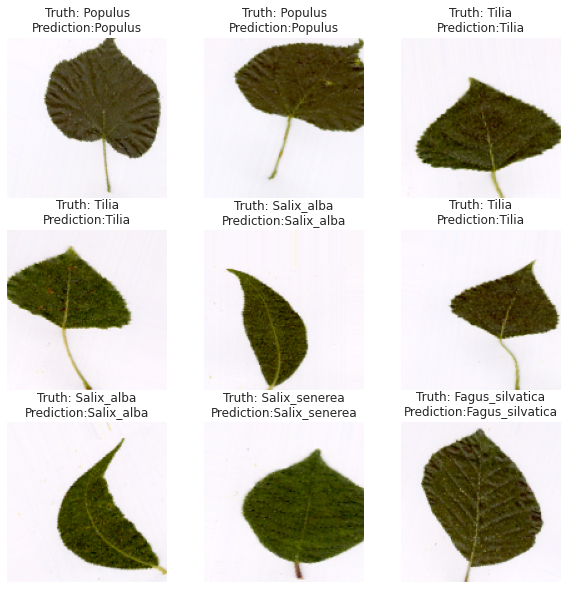

In [94]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict =model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label =coffee_classes[np.argmax(score)]
    plt.title(f'Truth: {coffee_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [95]:
model.save('InceptionResNetV2-baseline.h5')

# Initialize a new W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='10plantleaves', 
                 config=CONFIG,
                 group='InceptionResNetV2', 
                 job_type='save') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Save model as Model Artifact
artifact = wandb.Artifact(name='InceptionResNetV2', type='model')
artifact.add_file('InceptionResNetV2-baseline.h5')
run.log_artifact(artifact)

# Finish W&B run
run.finish()